In [ ]:
# —— 只需执行一次 ——
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# 自动定位你的 CICIoT2023 目录（找不到就用常见默认路径）
import os, glob

cands = glob.glob('/content/drive/MyDrive/**/CICIoT2023', recursive=True)
if cands:
    ROOT_DIR = cands[0]
else:
    ROOT_DIR = '/content/drive/MyDrive/INCS870/CICIoT2023'  # 你的常用路径

assert os.path.isdir(ROOT_DIR), f"路径不存在，请检查: {ROOT_DIR}"
print("ROOT_DIR =", ROOT_DIR)
print("children:", os.listdir(ROOT_DIR)[:12])
CLASS_DIR_WHITELIST = [
    "Benign_final",
    "BrowserHijacking",
    "DDoS_HTTP",
    "DDoS_ICMP",
    "DDoS_SYN",
    "DDoS_TCP",
    "DDoS_UDP",
    "DictionaryBruteForce",
    "DNS_Spoofing",
    "MITM-ArpSpoofing",
]
print("Class dirs (whitelist):", CLASS_DIR_WHITELIST)


ROOT_DIR = /content/drive/MyDrive/INCS870/CICIoT2023
children: ['Benign_final', '.ipynb_checkpoints', 'DDos_TCP', 'DDos_UDP', 'BroadLearningSystemMergeExclusiveFeatures.py', 'BroadLearningSystemGreedyBundling2.py', 'BrowserHijacking', 'DDos_HTTP', 'DDos_SYN', 'DDos_ICMP', 'DictionaryBruteForce', 'MITM-ArpSpoofing']
Class dirs (whitelist): ['Benign_final', 'BrowserHijacking', 'DDoS_HTTP', 'DDoS_ICMP', 'DDoS_SYN', 'DDoS_TCP', 'DDoS_UDP', 'DictionaryBruteForce', 'DNS_Spoofing', 'MITM-ArpSpoofing']


In [ ]:
# --- Smart CSV reader (run this BEFORE the loop over `pairs`) ---
import pandas as pd

def smart_read_csv(path):
    """
    尝试多种安全读取方式；自动跳过坏行、容忍编码问题。
    返回：pd.DataFrame
    """
    trials = [
        dict(engine="python", low_memory=False),
        dict(engine="python", low_memory=False, on_bad_lines="skip"),        # pandas ≥1.4
        dict(engine="python", low_memory=False, encoding_errors="ignore"),
        dict(engine="python", low_memory=False, encoding="latin1", on_bad_lines="skip"),
    ]
    # 兼容老版 pandas 的参数名
    legacy = dict(engine="python", low_memory=False, error_bad_lines=False, warn_bad_lines=False)
    for opts in trials + [legacy]:
        try:
            return pd.read_csv(path, **{k:v for k,v in opts.items() if k in pd.read_csv.__code__.co_varnames})
        except Exception:
            continue
    # 最后再尝试一次最简单的读取
    return pd.read_csv(path, engine="python", low_memory=False)


In [ ]:
# ========= 0) Imports =========
import os, re, glob, unicodedata, pathlib
import pandas as pd

# ========= 1) 目录名宽松匹配（你原来的） =========
def _canon_loose(s: str) -> str:
    # NFC 归一化；去掉空白、转小写、仅保留字母数字和部分分隔符
    s2 = unicodedata.normalize("NFC", str(s)).replace("\u200b", "").strip().lower()
    return re.sub(r"[^a-z0-9/_\-\.]", "", s2)

# ========= 2) 审计 + 扫描 CSV（你原来的） =========
def find_csvs_per_class_robust(root, class_dirs):
    real_dirs = []
    loose2real = {}
    for p in pathlib.Path(root).iterdir():
        if p.is_dir():
            real_dirs.append(p)
            loose2real[_canon_loose(p.name)] = str(p)

    # 尽量兜住不同大小写/命名差异
    patterns = ["**/*.csv", "**/*pcap.csv", "**/*-pcap.csv", "**/*CSV*"]

    print(f"[Audit+] ROOT_DIR = {root}")
    pairs, report = [], []

    for want in class_dirs:
        loose_want = _canon_loose(want)
        real = loose2real.get(loose_want, None)
        if real is None:
            print(f" - [MISS] {want:<16} | dir not found under ROOT_DIR")
            report.append({"class_dir": want, "exists": False, "count": 0, "examples": []})
            continue

        hits = set()
        for pat in patterns:
            hits.update(glob.glob(os.path.join(real, pat), recursive=True))
        hits = sorted(hits)

        if not hits:
            print(f" - [OK ] {want:<16} | CSVs: 0 | ex: []")
            report.append({"class_dir": want, "exists": True, "count": 0, "examples": []})
            continue

        print(f" - [OK ] {want:<16} | CSVs: {len(hits):<2} | ex: { [os.path.basename(p) for p in hits[:2]] }")
        report.append({"class_dir": want, "exists": True, "count": len(hits), "examples": hits[:2]})
        pairs.extend([(want, p) for p in hits])

    print(f"Total CSVs found: {len(pairs)} under {len(class_dirs)} class dirs.")
    return pairs, report

# ========= 3) 关键修复：鲁棒 CSV 读取 =========
def smart_read_csv(path):
    """
    多策略读取 CSV，兼容 pandas 新旧版本：
    - C/default 引擎：允许 low_memory / on_bad_lines
    - Python 引擎：不传 low_memory，必要时 on_bad_lines='skip' 与 encoding_errors='ignore'
    """
    trials = [
        dict(engine=None, low_memory=False),
        dict(engine=None, on_bad_lines="skip"),
        dict(engine='c', low_memory=False),
        dict(engine='c', on_bad_lines='skip'),

        # Python 引擎（切记不要传 low_memory！）
        dict(engine='python', on_bad_lines='skip'),
        dict(engine='python', encoding_errors='ignore', on_bad_lines='skip'),
        dict(engine='python'),
    ]
    last_err = None
    for kw in trials:
        k = dict(kw)
        if k.get('engine') == 'python':
            k.pop('low_memory', None)  # 关键：python 引擎不支持
        try:
            return pd.read_csv(path, **k)
        except TypeError:
            # 旧版 pandas 可能没有 on_bad_lines/encoding_errors
            k.pop('on_bad_lines', None)
            k.pop('encoding_errors', None)
            try:
                return pd.read_csv(path, **k)
            except Exception as e2:
                last_err = e2
        except Exception as e:
            last_err = e
            continue
    raise last_err

# ========= 4) 运行：审计 + 读取 + 合并（与你原来一致） =========
# 这俩在你前面已经定义过；如果没定义，请先设置它们
# ROOT_DIR = '/content/drive/MyDrive/INCS870/CICIoT2023'
# CLASS_DIR_WHITELIST = ["Benign_final","BrowserHijacking","DDoS_HTTP","DDoS_ICMP",
#                        "DDoS_SYN","DDoS_TCP","DDoS_UDP","DictionaryBruteForce",
#                        "DNS_Spoofing","MITM-ArpSpoofing"]

pairs, report = find_csvs_per_class_robust(ROOT_DIR, CLASS_DIR_WHITELIST)

dfs = []
for cls, path in pairs:
    df = smart_read_csv(path)        # ← 用新的读取函数
    df["__label__"] = cls
    dfs.append(df)

# 只保留公共列，且确保标签列在内
common_cols = set(dfs[0].columns)
for d in dfs[1:]:
    common_cols &= set(d.columns)
if "__label__" not in common_cols:
    common_cols.add("__label__")

df_full = pd.concat([d[list(common_cols)].copy() for d in dfs], ignore_index=True)
print("Raw merged shape:", df_full.shape)



[Audit+] ROOT_DIR = /content/drive/MyDrive/INCS870/CICIoT2023
 - [OK ] Benign_final     | CSVs: 2  | ex: ['BenignTraffic1.pcap.csv', 'BenignTraffic3.pcap.csv']
 - [OK ] BrowserHijacking | CSVs: 1  | ex: ['BrowserHijacking.pcap.csv']
 - [OK ] DDoS_HTTP        | CSVs: 1  | ex: ['DDoS-HTTP_Flood-.pcap.csv']
 - [OK ] DDoS_ICMP        | CSVs: 2  | ex: ['DDoS-ICMP_Flood.pcap.csv', 'DDoS-ICMP_Flood1.pcap.csv']
 - [OK ] DDoS_SYN         | CSVs: 2  | ex: ['DDoS-SYN_Flood.pcap.csv', 'DDoS-SYN_Flood1.pcap.csv']
 - [OK ] DDoS_TCP         | CSVs: 2  | ex: ['DDoS-TCP_Flood.pcap.csv', 'DDoS-TCP_Flood1.pcap.csv']
 - [OK ] DDoS_UDP         | CSVs: 2  | ex: ['DDoS-UDP_Flood1.pcap.csv', 'DDoS-UDP_Flood20.pcap.csv']
 - [OK ] DictionaryBruteForce | CSVs: 1  | ex: ['DictionaryBruteForce.pcap.csv']
 - [OK ] DNS_Spoofing     | CSVs: 1  | ex: ['DNS_Spoofing.pcap.csv']
 - [OK ] MITM-ArpSpoofing | CSVs: 2  | ex: ['MITM-ArpSpoofing.pcap.csv', 'MITM-ArpSpoofing1.pcap.csv']
Total CSVs found: 16 under 10 class dirs.

In [ ]:
# ===== 10 个规范特征名（严格按你汇报的顺序）=====
FEATURES_10_CANON = [
    "Rate",        # 流量速率
    "IAT",         # 包到达间隔
    "Variance",    # 波动/方差
    "Tot_sum",     # 累计量/总量
    "HTTP",
    "IGMP",
    "DHCP",
    "DNS",
    "ICMP",
    "SSH",
]

# ===== 同义词表（键用规范名的小写/归一化形式；值里写可能出现在CSV里的列名变体）=====
FEATURE_SYNONYMS = {
    # 连字符/空格/大小写都会在 canonicalize_name 里被统一，无需手工全枚举
    "rate": [
        "flow_rate","flowrate","pkt_rate","packet_rate","bytes_rate",
        "rate_s","flow_bytes_rate","flow_packets_rate","traffic_rate"
    ],
    "iat": [
        "inter_arrival_time","avg_iat","mean_iat","iat_mean",
        "pkt_iat","time_between_packets"
    ],
    "variance": [
        "var","flow_variance","variance_value","var_value"
    ],
    "tot_sum": [
        "total","total_sum","totalsum","sum_total",
        "byte_total","total_bytes","bytes_total","tot_bytes",
        "total_size","tot_size","sum_bytes","sum_packets",
        "packet_total","pkts_total"
    ],
    "http": ["is_http","proto_http","http_flag","flag_http","http_count"],
    "igmp": ["is_igmp","proto_igmp","igmp_flag","igmp_count"],
    "dhcp": ["is_dhcp","proto_dhcp","dhcp_flag","dhcp_count"],
    "dns":  ["is_dns","proto_dns","dns_flag","dns_count"],
    "icmp": ["is_icmp","proto_icmp","icmp_flag","icmp_count"],
    "ssh":  ["is_ssh","proto_ssh","ssh_flag","ssh_count"],
}

print("FEATURES_10_CANON =", FEATURES_10_CANON)


FEATURES_10_CANON = ['Rate', 'IAT', 'Variance', 'Tot_sum', 'HTTP', 'IGMP', 'DHCP', 'DNS', 'ICMP', 'SSH']


In [ ]:
import re, unicodedata
import numpy as np, pandas as pd

# —— 1) 列名归一化（保留字母数字与下划线/短横线，去空白并小写）
def canonicalize_name(s: str) -> str:
    s = unicodedata.normalize("NFC", str(s))
    s = s.strip().lower()
    s = re.sub(r"[\s\-]+", "_", s)           # 空格/短横线 → 下划线
    s = re.sub(r"[^a-z0-9_]", "", s)         # 仅保留字母/数字/下划线
    return s

# —— 2) 构建“规范名 → 实际列名”的映射
def resolve_feature_columns(
    df: pd.DataFrame,
    canon_features: list[str],
    synonyms: dict[str, list[str]]
) -> tuple[dict[str, str | None], dict[str, str]]:
    """
    返回：
      feat_map: {规范名: 实际列名或 None}
      actual_norm: {归一化后的实际列名: 原始列名}（用于debug）
    """
    # 实际列的“规范化索引表”
    actual_norm = {canonicalize_name(c): c for c in df.columns}
    feat_map: dict[str, str | None] = {}

    for canon in canon_features:
        key = canonicalize_name(canon)

        # 候选：自己 + 同义词
        cands = [key] + [canonicalize_name(x) for x in synonyms.get(key, [])]

        picked = None
        # 1) 精确命中：规范化后刚好有
        for k in cands:
            if k in actual_norm:
                picked = actual_norm[k]; break

        # 2) 宽松匹配：对 df.columns 再做一遍 canonicalize，找等价
        if picked is None:
            for raw in df.columns:
                if canonicalize_name(raw) == key:
                    picked = raw; break

        if picked is None:
            print(f"[WARN] Feature '{canon}' not found; will create zero-filled column.")
            feat_map[canon] = None
        else:
            feat_map[canon] = picked

    return feat_map, actual_norm

# —— 3) 依据映射生成 X10：缺列零填、类型统一、顺序固定
def make_X10_from_map(
    df: pd.DataFrame,
    feat_map: dict[str, str | None],
    canon_order: list[str],
    proto_flags: list[str] = ("HTTP","IGMP","DHCP","DNS","ICMP","SSH"),
) -> pd.DataFrame:
    X_list = []
    for canon in canon_order:
        real = feat_map.get(canon)
        if real is None:
            col = pd.Series(0.0, index=df.index, name=canon)
        else:
            col = pd.to_numeric(df[real], errors="coerce")        # 尽量转数值
            col = col.replace([np.inf, -np.inf], np.nan).fillna(0)
            col = col.astype("float32")
            col.name = canon
        X_list.append(col)

    X10 = pd.concat(X_list, axis=1)

    # 协议位/计数列统一到 0/1（>0 视为 1）
    for p in proto_flags:
        if p in X10.columns:
            X10[p] = (X10[p] > 0).astype("float32")

    # 其它列统一 float32
    for c in X10.columns:
        if X10[c].dtype != "float32":
            X10[c] = X10[c].astype("float32")

    return X10

# —— 4) 调用：产出映射 + X10
#    假设 df_full 含有 "__label__"，且你已定义 FEATURES_10_CANON / FEATURE_SYNONYMS
df_nolabel = df_full.drop(columns=["__label__"], errors="ignore")
feat_map, actual_norm = resolve_feature_columns(df_nolabel, FEATURES_10_CANON, FEATURE_SYNONYMS)

# 映射表查看（放进slide也很好）
mapping_df = pd.DataFrame({
    "canonical_feature": FEATURES_10_CANON,
    "csv_column_used": [feat_map[c] if feat_map[c] is not None else "[filled 0]" for c in FEATURES_10_CANON]
})
display(mapping_df)

# 生成 X10，严格按 FEATURES_10_CANON 排序
X10 = make_X10_from_map(df_nolabel, feat_map, FEATURES_10_CANON)
y_all = df_full["__label__"].to_numpy()

print("After mapping:", X10.shape, "dtype:", dict(X10.dtypes))
display(X10.head())



,canonical_feature,csv_column_used
0,Rate,Rate
1,IAT,IAT
2,Variance,Variance
3,Tot_sum,Tot sum
4,HTTP,HTTP
5,IGMP,IGMP
6,DHCP,DHCP
7,DNS,DNS
8,ICMP,ICMP
9,SSH,SSH


After mapping: (2909041, 10) dtype: {'Rate': dtype('float32'), 'IAT': dtype('float32'), 'Variance': dtype('float32'), 'Tot_sum': dtype('float32'), 'HTTP': dtype('float32'), 'IGMP': dtype('float32'), 'DHCP': dtype('float32'), 'DNS': dtype('float32'), 'ICMP': dtype('float32'), 'SSH': dtype('float32')}


,Rate,IAT,Variance,Tot_sum,HTTP,IGMP,DHCP,DNS,ICMP,SSH
0,111.733093,0.008950,1031498.875,8010.0,0.0,0.0,0.0,1.0,0.0,0.0
1,905.799377,0.001122,1490989.500,20932.0,0.0,0.0,0.0,0.0,0.0,0.0
2,931.177734,0.001091,3750770.500,25276.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1419.440308,0.000814,0.000,660.0,0.0,0.0,0.0,0.0,0.0,0.0
4,211.585617,0.004726,372747.375,3556.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from collections import Counter

RANDOM_STATE = 42

# 1) 连续列标准化（协议位保持 0/1）
cont = ["Rate","IAT","Variance","Tot_sum"]
X_scaled = X10.copy()
X_scaled[cont] = StandardScaler().fit_transform(X_scaled[cont])

# 2) 安全地抽样成 100×10（每类最多 cap 条，过少的类自动跳过；不足 100 再从剩余样本补齐）
def build_demo(X_df: pd.DataFrame, y, total=100, per_class_cap=10, min_per_class=2, random_state=42):
    rng = np.random.default_rng(random_state)
    y_enc, classes = pd.factorize(y)          # 数字化标签
    idx_by_class = {i: np.flatnonzero(y_enc==i) for i,_ in enumerate(classes)}
    take = []
    for i, idx in idx_by_class.items():
        k = min(per_class_cap, len(idx))
        if k < min_per_class:    # 太稀疏的类不纳入 DEMO
            continue
        sel = rng.choice(idx, size=k, replace=False)
        take.append(sel)
    if len(take)==0:
        raise RuntimeError("所有类别都太稀疏，无法构建 DEMO，请调小 min_per_class 或 per_class_cap。")
    sel = np.concatenate(take)

    # 若超出 total，则下采样；若不足 total，则从剩余样本补齐
    if len(sel) > total:
        sel = rng.choice(sel, size=total, replace=False)
    elif len(sel) < total:
        rest = np.setdiff1d(np.arange(len(y_enc)), sel, assume_unique=False)
        add = min(total - len(sel), len(rest))
        if add > 0:
            sel = np.concatenate([sel, rng.choice(rest, size=add, replace=False)])

    X_demo = X_df.iloc[sel].reset_index(drop=True)
    y_demo = y_enc[sel]
    return X_demo, y_demo, classes, sel

X_demo, y_demo, classes, idx_demo = build_demo(
    X_scaled, y_all, total=100, per_class_cap=10, min_per_class=2, random_state=RANDOM_STATE
)

print("DEMO shape:", X_demo.shape, "(expect (100, 10))")
print("Class distribution in DEMO:", dict(Counter(y_demo)))
display(X_demo.head())



DEMO shape: (100, 10) (expect (100, 10))
Class distribution in DEMO: {np.int64(0): 10, np.int64(1): 10, np.int64(2): 10, np.int64(3): 10, np.int64(4): 10, np.int64(5): 10, np.int64(6): 10, np.int64(7): 10, np.int64(8): 10, np.int64(9): 10}


,Rate,IAT,Variance,Tot_sum,HTTP,IGMP,DHCP,DNS,ICMP,SSH
0,-0.565099,-0.000989,2.094692,2.740715,0.0,0.0,0.0,0.0,0.0,0.0
1,8.849441,-0.001075,-0.174985,-1.278743,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.552448,-0.001041,0.417060,0.394643,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.560642,-0.001016,0.185175,-0.529258,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.568451,-0.000918,-0.174163,-1.257924,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# === 互信息（基于 DEMO）===
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import lightgbm as lgb
import numpy as np, pandas as pd

RANDOM_STATE = 42
X = X_demo.copy()
y = y_demo

mi = mutual_info_classif(X.values, y, random_state=RANDOM_STATE)

# === 基线 GBM (GBDT) ===
n_classes = len(np.unique(y))
is_multiclass = n_classes > 2
scoring = "f1_macro" if is_multiclass else "f1"

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

clf = lgb.LGBMClassifier(
    boosting_type="gbdt",
    objective="multiclass" if is_multiclass else "binary",
    # 多分类时不必显式传 num_class；传也可以：num_class=n_classes
    learning_rate=0.1,
    num_leaves=31,
    max_bin=127,
    n_estimators=200,
    random_state=RANDOM_STATE,
)
clf.fit(X_tr, y_tr)

# gain 型特征重要性（与 LightGBM 论文一致）
gain = clf.booster_.feature_importance(importance_type="gain")

# 置换重要性（在测试集上，稳定性更好）
pi = permutation_importance(
    clf, X_te, y_te, n_repeats=20, random_state=RANDOM_STATE, scoring=scoring
)

# === 原始单位的均值/方差（可选，PPT里更直观）===
# 优先使用你保留的未标准化副本；否则尝试用 scaler 反变换连续列；再不行就回退到当前 X 的均值/方差
cont = ["Rate","IAT","Variance","Tot_sum"]
try:
    X_raw = X_demo_raw.copy()       # 如果你在标准化前保存了未标准化副本，就直接用它
except NameError:
    try:
        X_raw = X.copy()
        if 'scaler' in globals():
            X_raw[cont] = scaler.inverse_transform(X[cont])
    except Exception:
        X_raw = X.copy()            # 兜底（此时连续列是标准化后的均值≈0、std≈1）
        pass

result_table = pd.DataFrame({
    "feature":        X.columns,
    "mean_raw":       X_raw.mean().values,
    "std_raw":        X_raw.std(ddof=0).values,
    "mutual_info":    mi,
    "gain_importance":gain,
    "pi_mean":        pi.importances_mean,
    "pi_std":         pi.importances_std,
}).sort_values(["pi_mean","gain_importance"], ascending=False).reset_index(drop=True)

pd.set_option('display.float_format', lambda x: f"{x:.4f}")
display(result_table)

# 保存 CSV（便于直接贴到 PPT）
out_csv = "/content/feature_results_10.csv"
result_table.to_csv(out_csv, index=False)
print("Saved result table to:", out_csv)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 95
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 4
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

,feature,mean_raw,std_raw,mutual_info,gain_importance,pi_mean,pi_std
0,Tot_sum,0.1509,1.7008,0.5940,492.6451,0.0367,0.0520
1,HTTP,0.2100,0.4073,0.2015,0.0000,0.0000,0.0000
2,IGMP,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,DHCP,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,DNS,0.1300,0.3363,0.0096,0.0000,0.0000,0.0000
5,ICMP,0.1700,0.3756,0.2275,0.0000,0.0000,0.0000
6,SSH,0.0400,0.1960,0.1139,0.0000,0.0000,0.0000
7,Variance,0.0434,0.6156,0.3974,319.0990,-0.0224,0.0403
8,IAT,-0.0009,0.0003,0.5771,435.7565,-0.0772,0.0590
9,Rate,-0.0577,1.2970,0.5666,532.2706,-0.1120,0.0593


Saved result table to: /content/feature_results_10.csv


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 8
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training f

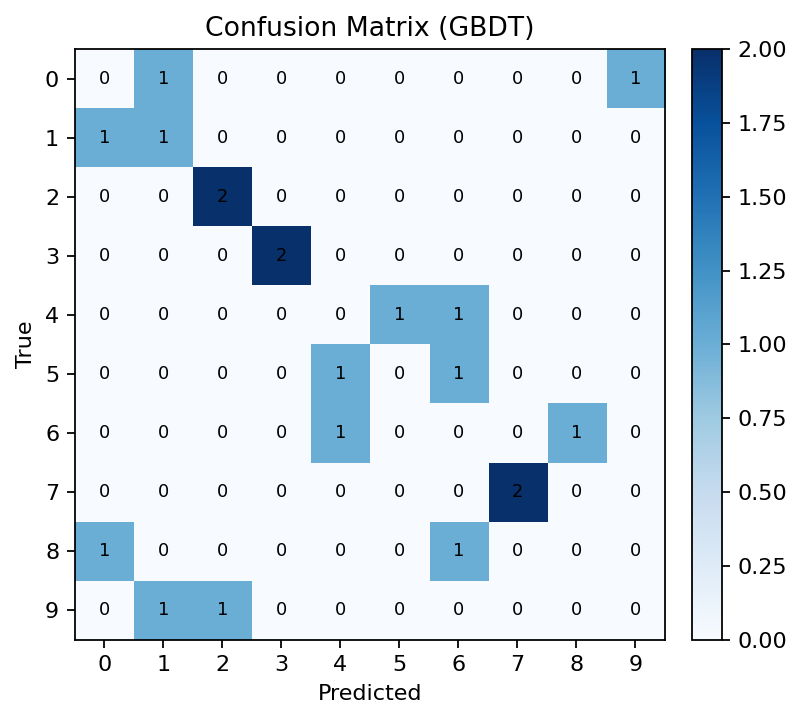

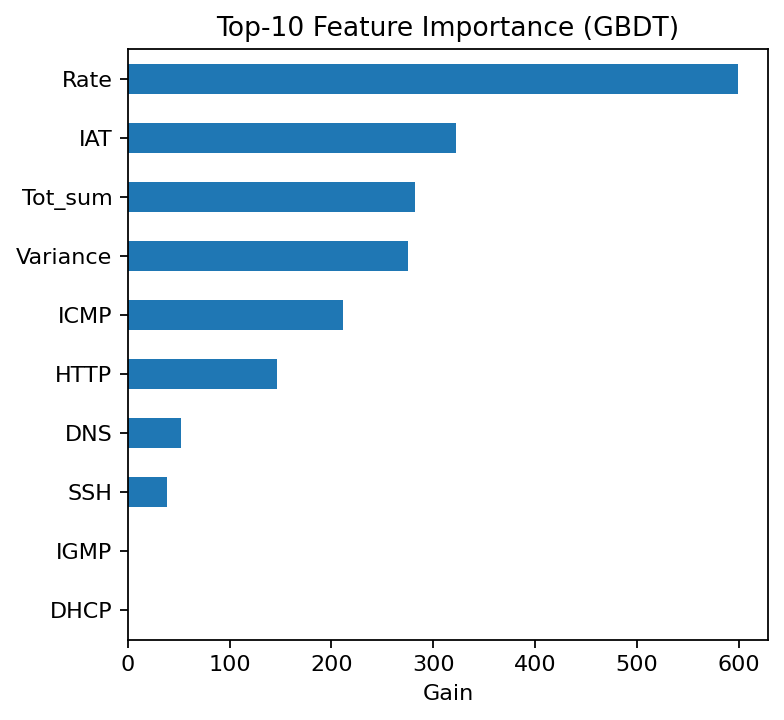

,Acc,F1,Rec
0,0.3500,0.3200,0.3500


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score
import lightgbm as lgb

RANDOM_STATE = 42

# 1) 训练 GBDT 基线
classes = np.unique(y_demo)
multiclass = len(classes) > 2
avg = "macro" if multiclass else "binary"

clf_gbdt = lgb.LGBMClassifier(
    boosting_type="gbdt",
    objective="multiclass" if multiclass else "binary",
    learning_rate=0.1, n_estimators=150, num_leaves=15,
    max_bin=63, min_data_in_leaf=1, random_state=RANDOM_STATE
)

X_tr, X_te, y_tr, y_te = train_test_split(
    X_demo, y_demo, test_size=0.2, stratify=y_demo, random_state=RANDOM_STATE
)
clf_gbdt.fit(X_tr, y_tr)
y_pred = clf_gbdt.predict(X_te)

acc = accuracy_score(y_te, y_pred)
f1  = f1_score(y_te, y_pred, average=avg)
rec = recall_score(y_te, y_pred, average=avg)
print(f"GBDT on DEMO  ->  Acc: {acc:.2f}  F1: {f1:.2f}  Rec: {rec:.2f}")

# 2) 混淆矩阵（保存为 PNG，放中间）
cm = confusion_matrix(y_te, y_pred, labels=classes)
fig, ax = plt.subplots(figsize=(5.2,4.6), dpi=160)
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
ax.set_xticklabels(classes); ax.set_yticklabels(classes)
ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("Confusion Matrix (GBDT)")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i,j], ha="center", va="center", fontsize=8)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig("cm_gbdt_demo.png"); plt.show()

# 3) 特征重要性（gain）Top-10（保存为 PNG，放右侧）
gain = pd.Series(
    clf_gbdt.booster_.feature_importance(importance_type="gain"),
    index=X_demo.columns, name="gain_importance"
).sort_values(ascending=True)  # 先升序，条形图从下往上更美观
fig, ax = plt.subplots(figsize=(5.0,4.6), dpi=160)
gain.tail(10).plot(kind="barh", ax=ax)
ax.set_xlabel("Gain"); ax.set_title("Top-10 Feature Importance (GBDT)")
plt.tight_layout()
plt.savefig("featimp_gbdt_demo.png"); plt.show()

# 4) 方便复制到 PPT 的关键数字
metrics_gbdt = pd.DataFrame(
    {"Acc":[acc], "F1":[f1], "Rec":[rec]}
).round(3)
metrics_gbdt


In [ ]:
#GBM 演示（GBDT & GOSS 一键切换）
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
import numpy as np, pandas as pd
import lightgbm as lgb

RANDOM_STATE = 42

def run_gbm_demo(X, y, boosting_type="gbdt", title=None):
    y = np.asarray(y)
    classes = np.unique(y)
    multiclass = len(classes) > 2

    # 公共参数
    common = dict(
        objective   = "multiclass" if multiclass else "binary",
        num_class   = len(classes) if multiclass else None,
        learning_rate = 0.1,
        n_estimators  = 150,
        num_leaves    = 15,
        max_depth     = -1,
        min_data_in_leaf = 1,
        min_split_gain   = 0.0,
        max_bin          = 63,
        random_state     = RANDOM_STATE,
    )

    # 构建模型
    if boosting_type == "goss":
        clf = lgb.LGBMClassifier(boosting_type="goss",
                                 top_rate=0.2, other_rate=0.1, **common)
    else:
        clf = lgb.LGBMClassifier(boosting_type="gbdt", **common)

    # 分层划分 + 训练
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
    )
    clf.fit(X_tr, y_tr)

    # 评估
    y_pred = clf.predict(X_te)
    avg = "macro" if multiclass else "binary"
    acc = accuracy_score(y_te, y_pred)
    f1  = f1_score(y_te, y_pred, average=avg)
    rec = recall_score(y_te, y_pred, average=avg)

    print(title or f"GBM ({boosting_type.upper()})",
          " Acc:", round(acc,2), " F1:", round(f1,2), " Rec:", round(rec,2))

    cm = confusion_matrix(y_te, y_pred, labels=classes)
    display(pd.DataFrame(cm, index=classes, columns=classes))
    return clf

# —— 演示（注意：用 X_demo / y_demo）——
clf_gbdt = run_gbm_demo(X_demo, y_demo, "gbdt", title="== GBM (GBDT) on DEMO ==")
clf_goss = run_gbm_demo(X_demo, y_demo, "goss", title="== GBM (GOSS) on DEMO ==")

imp = pd.Series(clf_goss.booster_.feature_importance(importance_type="gain"),
                index=X_demo.columns).sort_values(ascending=False)
display(imp)




[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 8
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training f

,0,1,2,3,4,5,6,7,8,9
0,0,1,0,0,0,0,0,0,0,1
1,1,1,0,0,0,0,0,0,0,0
2,0,0,2,0,0,0,0,0,0,0
3,0,0,0,2,0,0,0,0,0,0
4,0,0,0,0,0,1,1,0,0,0
5,0,0,0,0,1,0,1,0,0,0
6,0,0,0,0,1,0,0,0,1,0
7,0,0,0,0,0,0,0,2,0,0
8,1,0,0,0,0,0,1,0,0,0
9,0,1,1,0,0,0,0,0,0,0


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102
[LightGBM] [Info] Number of data points in the train set: 80, number of use

,0,1,2,3,4,5,6,7,8,9
0,0,1,0,0,0,0,0,0,0,1
1,1,1,0,0,0,0,0,0,0,0
2,0,0,2,0,0,0,0,0,0,0
3,0,0,0,2,0,0,0,0,0,0
4,0,0,0,0,0,1,1,0,0,0
5,0,0,0,0,1,0,1,0,0,0
6,0,0,0,0,1,1,0,0,0,0
7,0,0,0,0,0,0,0,2,0,0
8,1,0,0,0,0,0,1,0,0,0
9,0,2,0,0,0,0,0,0,0,0


,0
Rate,735.7464
IAT,343.5192
Tot_sum,340.0536
Variance,331.2883
ICMP,216.4115
HTTP,151.8548
DNS,57.7813
SSH,43.4664
IGMP,0.0000
DHCP,0.0000


In [ ]:
#EFB 独立 I/O 演示（pack / unpack）
# --- EFB：把近似互斥的若干 0/1 列打成 1 列（带可逆映射） ---
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score
import lightgbm as lgb

RANDOM_STATE = 42

# 你要打包的“互斥/近似互斥列”
PROTO = ["HTTP", "IGMP", "DHCP", "DNS", "ICMP", "SSH"]

def efb_pack_offset(X_df: pd.DataFrame, groups: list[list[str]]):
    """
    把 groups 中的每个组打成 1 列；非组内列保持原样。
    使用累加偏移（offset）避免冲突：offset >= 前一列最大值 + 1。
    返回：
      X_packed  : 打包后的 DataFrame
      inv_map   : 逆映射（每个新列对应了原列名+偏移细节）
    """
    X = X_df.copy()
    col2idx = {c:i for i,c in enumerate(X.columns)}
    used = set()
    packed_cols = []
    inv_map = []

    for g in groups:
        g = [c for c in g if c in col2idx]      # 只打包存在的列
        if len(g) <= 1:
            continue
        base = 0.0
        new = np.zeros((X.shape[0],), dtype=float)
        details = []
        for c in g:
            v = X[c].to_numpy(dtype=float)
            vmax = np.nanmax(v) if np.isfinite(np.nanmax(v)) else 0.0
            step = (vmax if vmax>0 else 0.0) + 1.0    # 安全边界
            new += v + base
            details.append((c, float(base), float(step)))
            base += step
            used.add(c)
        packed_cols.append(new)
        inv_map.append(details)

    # 剩余未打包列 + 新列
    remain = [c for c in X.columns if c not in used]
    out = pd.DataFrame(index=X.index)
    for c in remain:
        out[c] = X[c].values
    # 新列命名：bundle_0, bundle_1, ...
    for k, col in enumerate(packed_cols):
        out[f"bundle_{k}"] = col

    # 让列顺序更友好：先放连续 4 列，再放新 bundle，再放剩余（如果有）
    cont = ["Rate","IAT","Variance","Tot_sum"]
    ordered = [c for c in cont if c in out.columns] + \
              [f"bundle_{k}" for k in range(len(packed_cols))] + \
              [c for c in out.columns if c not in cont and not c.startswith("bundle_")]
    out = out[ordered]

    return out, inv_map

def efb_report_overlap(X, cols):
    """统计组内列在一行中同时为 1 的情况比例（越小越接近互斥）"""
    sub = X[cols].to_numpy()
    cnt = (sub.sum(axis=1) > 1).mean() if sub.size else 0.0
    return float(cnt)

def run_efb_demo(X, y, groups):
    # 打包前互斥性检查（给课堂讲解的数字）
    overlap = efb_report_overlap(X, PROTO)
    print(f"Overlap ratio in PROTO (rows with >1 active flags): {overlap:.4%}")

    X_packed, inv_map = efb_pack_offset(X, groups)
    print("Original shape:", X.shape, " -> Packed shape:", X_packed.shape)
    print("Bundles:")
    for bi, det in enumerate(inv_map):
        print(f"  bundle_{bi}: {[d[0] for d in det]}")

    # 训练一个基线 GBDT 验证效果（随手复用之前的设置）
    classes = np.unique(y)
    multiclass = len(classes) > 2
    avg = "macro" if multiclass else "binary"

    clf = lgb.LGBMClassifier(
        boosting_type="gbdt",
        objective="multiclass" if multiclass else "binary",
        learning_rate=0.1,
        n_estimators=150,
        num_leaves=15,
        max_bin=63,
        min_data_in_leaf=1,
        random_state=RANDOM_STATE,
    )
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_packed, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
    )
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    f1  = f1_score(y_te, y_pred, average=avg)
    rec = recall_score(y_te, y_pred, average=avg)
    print(f"[Packed] Acc: {acc:.2f}  F1: {f1:.2f}  Rec: {rec:.2f}")

    return X_packed, inv_map, clf

# —— 演示调用（用 X_demo / y_demo！）——
groups = [PROTO]   # 六个协议位作为一个 bundle
X_packed, inv_map, clf_packed = run_efb_demo(X_demo, y_demo, groups)


Overlap ratio in PROTO (rows with >1 active flags): 13.0000%
Original shape: (100, 10)  -> Packed shape: (100, 5)
Bundles:
  bundle_0: ['HTTP', 'IGMP', 'DHCP', 'DNS', 'ICMP', 'SSH']
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 5
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start t

In [ ]:
import os, re, difflib, glob, pathlib as pl

ROOT_DIR = "/content/drive/MyDrive/INCS870/CICIoT2023"
WANTED = [
    "Benign_final","BrowserHijacking",
    "DDoS_HTTP","DDoS_ICMP","DDoS_SYN","DDoS_TCP","DDoS_UDP",
    "DictionaryBruteForce","DNS_Spoofing","MITM-ArpSpoofing"
]

def canon(s:str)->str:
    return re.sub(r"[^a-z0-9]+","", s.lower())

# 顶层真实目录 → 标准化映射
real_dirs = [d for d in os.listdir(ROOT_DIR) if os.path.isdir(os.path.join(ROOT_DIR, d))]
canon2real = {canon(d): d for d in real_dirs}

mapped = {}
missing = []
for w in WANTED:
    cw = canon(w)
    if cw in canon2real:
        mapped[w] = canon2real[cw]
    else:
        # 找最接近的候选（帮助你确认）
        close = difflib.get_close_matches(cw, list(canon2real.keys()), n=3, cutoff=0.6)
        close_show = [canon2real[k] for k in close]
        print(f"[WARN] '{w}' not found at top-level. Close candidates: {close_show}")
        missing.append(w)

print("\n[Mapping decided]")
for k,v in mapped.items():
    print(f" - {k:18s} -> {v}")

CLASS_DIRS_FINAL = [mapped[w] for w in WANTED if w in mapped]  # 只用匹配成功的，先跑通

import glob, os

def audit_root(root_dir, class_dirs):
    print(f"[Audit] ROOT_DIR = {root_dir}")
    tot = 0
    for cls in class_dirs:
        cdir = os.path.join(root_dir, cls)
        ok = os.path.isdir(cdir)
        files = glob.glob(os.path.join(cdir, "**", "*.[cC][sS][vV]"), recursive=True) if ok else []
        print(f" - [{'OK ' if ok else 'MISS'}] {cls:18s} | CSVs: {len(files):>2} | ex: {files[:2]}")
        tot += len(files)
    print(f"Total CSVs found: {tot} under {len(class_dirs)} class dirs.")

audit_root(ROOT_DIR, CLASS_DIRS_FINAL)




[Mapping decided]
 - Benign_final       -> Benign_final
 - BrowserHijacking   -> BrowserHijacking
 - DDoS_HTTP          -> DDos_HTTP
 - DDoS_ICMP          -> DDos_ICMP
 - DDoS_SYN           -> DDos_SYN
 - DDoS_TCP           -> DDos_TCP
 - DDoS_UDP           -> DDos_UDP
 - DictionaryBruteForce -> DictionaryBruteForce
 - DNS_Spoofing       -> DNS_Spoofing
 - MITM-ArpSpoofing   -> MITM-ArpSpoofing
[Audit] ROOT_DIR = /content/drive/MyDrive/INCS870/CICIoT2023
 - [OK ] Benign_final       | CSVs:  2 | ex: ['/content/drive/MyDrive/INCS870/CICIoT2023/Benign_final/BenignTraffic3.pcap.csv', '/content/drive/MyDrive/INCS870/CICIoT2023/Benign_final/BenignTraffic1.pcap.csv']
 - [OK ] BrowserHijacking   | CSVs:  1 | ex: ['/content/drive/MyDrive/INCS870/CICIoT2023/BrowserHijacking/BrowserHijacking.pcap.csv']
 - [OK ] DDos_HTTP          | CSVs:  1 | ex: ['/content/drive/MyDrive/INCS870/CICIoT2023/DDos_HTTP/DDoS-HTTP_Flood-.pcap.csv']
 - [OK ] DDos_ICMP          | CSVs:  2 | ex: ['/content/drive/MyDrive

In [ ]:
import os, glob, re, time, numpy as np, pandas as pd
from pathlib import Path

ROOT_DIR = "/content/drive/MyDrive/INCS870/CICIoT2023"   # 保持和你现在的一致
# 用你上一格得到的最终目录列表（mapped 后的真实目录名）
CLASS_DIRS_FINAL = [
    "Benign_final","Browserhijacking","DDoS_HTTP","DDoS_ICMP","DDoS_SYN",
    "DDoS_TCP","DDoS_UDP","DictionaryBruteForce","DNS_Spoofing","MITM-ArpSpoofing"
]

# 10 个“规范名”与可能别名（不区分大小写，去掉空格/下划线）
FEATURES_10_CANON = ["Rate","IAT","Variance","Tot_sum","HTTP","IGMP","DHCP","DNS","ICMP","SSH"]
FEATURE_SYNONYMS = {
    "Rate":    ["Rate","Flow Rate","rate"],
    "IAT":     ["IAT","InterArrivalTime","iat"],
    "Variance":["Variance","Var","Flow Var"],
    "Tot_sum": ["Tot_sum","Total","Tot sum","Sum"],
    "HTTP":    ["HTTP"],
    "IGMP":    ["IGMP"],
    "DHCP":    ["DHCP"],
    "DNS":     ["DNS"],
    "ICMP":    ["ICMP"],
    "SSH":     ["SSH"]
}
def canon(s): return re.sub(r"[^a-z0-9]+","", str(s).lower())


In [ ]:
def smart_read_csv(p):
    try:
        return pd.read_csv(p, low_memory=False)
    except Exception:
        # 有些是 pcap.csv，编码/分隔符偶发问题，可再兜底尝试
        return pd.read_csv(p, engine="python", low_memory=False)

def list_class_csvs(root, cls):
    return glob.glob(os.path.join(root, cls, "**", "*.[cC][sS][vV]"), recursive=True)

def resolve_feature_map(df, canon_names, synonyms):
    actual = {canon(c): c for c in df.columns}
    mapping = {}
    for key in canon_names:
        cands = [canon(key)] + [canon(x) for x in synonyms.get(key,[])]
        picked = None
        for k in cands:
            if k in actual:
                picked = actual[k]; break
        if picked is None:
            # 容错：尝试宽松匹配（去下划线/空格）
            for raw in df.columns:
                if canon(raw) == canon(key):
                    picked = raw; break
        mapping[key] = picked  # 可能为 None（后面用 0 补）
    return mapping

def load_full_df(root, class_dirs, canon_names, synonyms):
    dfs = []
    for cls in class_dirs:
        paths = list_class_csvs(root, cls)
        if not paths: continue
        # 仅取一个样例来解析列名（不同 CSV 列集一般一致）
        df0 = smart_read_csv(paths[0])
        fmap = resolve_feature_map(df0, canon_names, synonyms)

        for p in paths:
            d = smart_read_csv(p)
            row = {}
            for k in canon_names:
                real = fmap[k]
                if real is None or real not in d.columns:
                    row[k] = np.zeros(len(d))
                else:
                    row[k] = pd.to_numeric(d[real], errors="coerce").fillna(0).values
            out = pd.DataFrame(row)
            out["__label__"] = cls
            dfs.append(out)

    df_full = pd.concat(dfs, ignore_index=True)
    y = df_full["__label__"].astype("category").cat.codes.values
    X = df_full.drop(columns=["__label__"])
    return X, y, df_full

X_all, y_all, df_all = load_full_df(ROOT_DIR, CLASS_DIRS_FINAL, FEATURES_10_CANON, FEATURE_SYNONYMS)
print("Raw merged:", X_all.shape, "classes:", len(np.unique(y_all)))


Raw merged: (924939, 10) classes: 4


In [ ]:
from sklearn.utils import shuffle
from collections import Counter

RANDOM_STATE = 42
PER_CLASS_CAP = 10

def build_demo(X, y, per_class=10, seed=RANDOM_STATE):
    df = pd.DataFrame(X); df["__y__"] = y
    parts=[]
    for c in np.unique(y):
        sub = df[df["__y__"]==c]
        take = min(per_class, len(sub))
        parts.append(sub.sample(take, random_state=seed))
    demo = pd.concat(parts, ignore_index=True)
    demo = shuffle(demo, random_state=seed).reset_index(drop=True)
    y_demo = demo["__y__"].values
    X_demo = demo.drop(columns=["__y__"]).astype(np.float32).values
    print("DEMO shape:", X_demo.shape, "  class dist:", Counter(y_demo))
    return X_demo, y_demo

X10, y_demo = build_demo(X_all.values, y_all, PER_CLASS_CAP)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X10)
X10s = scaler.transform(X10)


DEMO shape: (40, 10)   class dist: Counter({np.int8(1): 10, np.int8(2): 10, np.int8(0): 10, np.int8(3): 10})


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 32, number of used features: 0
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped t

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


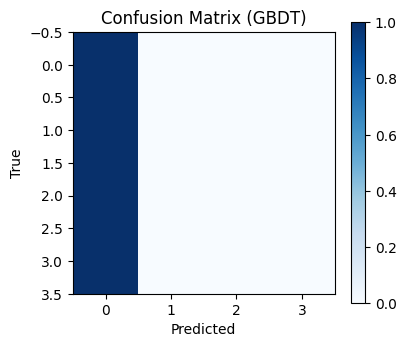

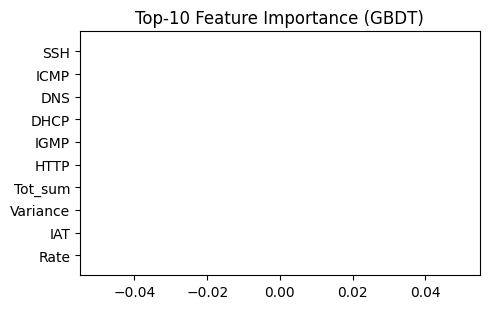

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 32, number of used features: 0
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


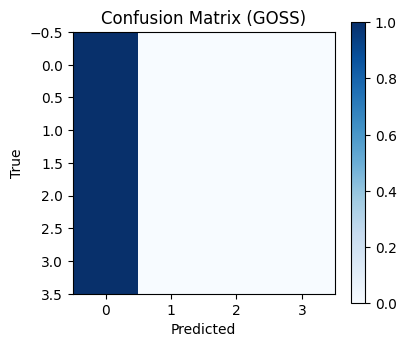

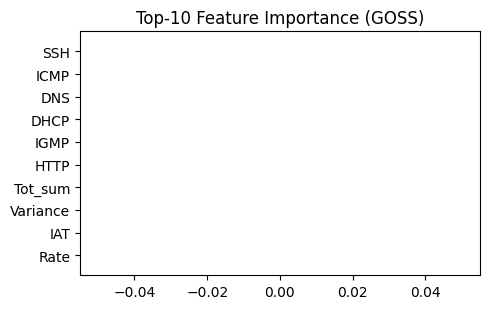

GBDT: (0.25, 0.1, 0.25)    GOSS: (0.25, 0.1, 0.25)


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt

def run_gbm(X, y, boosting="gbdt", title="GBM on DEMO"):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
    clf = lgb.LGBMClassifier(
        boosting_type=boosting,
        objective="multiclass" if len(np.unique(y))>2 else "binary",
        num_class=len(np.unique(y)) if len(np.unique(y))>2 else None,
        learning_rate=0.1, num_leaves=31, max_bin=63, n_estimators=120, random_state=RANDOM_STATE
    )
    t0 = time.perf_counter()
    clf.fit(X_tr, y_tr)
    t1 = time.perf_counter()

    y_pr = clf.predict(X_te)
    acc = accuracy_score(y_te, y_pr)
    f1  = f1_score(y_te, y_pr, average="macro")
    rec = recall_score(y_te, y_pr, average="macro")
    print(f"{title}  Acc={acc:.3f}  F1={f1:.3f}  Rec={rec:.3f}  (time {t1-t0:.3f}s)")

    # 混淆矩阵
    cm = confusion_matrix(y_te, y_pr, labels=np.unique(y))
    plt.figure(figsize=(4.2,3.6))
    plt.imshow(cm/cm.sum(axis=1, keepdims=True), cmap="Blues")
    plt.title(f"Confusion Matrix ({boosting.upper()})")
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.colorbar()
    plt.tight_layout(); plt.show()

    # 特征重要度（gain）
    gain = clf.booster_.feature_importance(importance_type="gain")
    plt.figure(figsize=(5,3.2))
    order = np.argsort(gain)[::-1][:10]
    plt.barh(np.array(FEATURES_10_CANON)[order][::-1], gain[order][::-1])
    plt.title(f"Top-10 Feature Importance ({boosting.upper()})"); plt.tight_layout(); plt.show()
    return clf, (acc, f1, rec)

clf_gbdt, m_gbdt = run_gbm(X10s, y_demo, "gbdt", "== GBDT on DEMO ==")
clf_goss, m_goss = run_gbm(X10s, y_demo, "goss", "== GOSS on DEMO ==")

print("GBDT:", m_gbdt, "   GOSS:", m_goss)


In [ ]:
# 仅把互斥协议列打包，其他 4 个连续特征保持不变
PROTO = ["HTTP","IGMP","DHCP","DNS","ICMP","SSH"]
keep  = ["Rate","IAT","Variance","Tot_sum"]

# 定位协议列索引
col_idx = {k:i for i,k in enumerate(FEATURES_10_CANON)}
groups = [ [col_idx[p] for p in PROTO if p in col_idx] ]  # 一组：所有协议
remain = [col_idx[k] for k in keep]

def efb_pack(X, groups, remain):
    X = np.asarray(X, dtype=np.float32)
    packed = X[:, remain].copy()
    inv_map = []  # 记录每一组每个列的 offset
    for g in groups:
        part = X[:, g]
        max_per_col = np.nanmax(np.where(np.isfinite(part), part, 0), axis=0)
        offsets = np.cumsum(np.r_[0, max_per_col[:-1] + 1e-6])  # very small gaps
        bundle = (part + offsets).max(axis=1, keepdims=True)
        packed = np.concatenate([packed, bundle], axis=1)
        inv_map.append((g, offsets))
    return packed, inv_map

def efb_unpack(X_packed, inv_map, X_columns):
    # 仅用于演示可逆：把最后一个 bundle 拆回协议列
    Xp = np.asarray(X_packed, dtype=np.float32)
    out = Xp[:, :len(keep)].copy()
    bundle = Xp[:, len(keep):]  # 一个 bundle
    g, offsets = inv_map[0]
    for i, off in enumerate(offsets):
        rec = np.maximum(bundle - off, 0.0).squeeze(1)
        # 为了与原 0/正值互斥语义一致，负值截断为 0
        out = np.column_stack([out, rec])
    # 列顺序回到原来的 10 列
    # rem(4) + g(6)  → 根据 col_idx 排序复位
    cols = keep + PROTO
    order = np.argsort([col_idx[c] for c in cols])
    out = out[:, order]
    return out

# 打包 & 训练计时
X10s_proto_first = X10s[:, [col_idx[k] for k in keep + PROTO]]  # 顺序确保 keep 在前、proto 在后
Xp, inv = efb_pack(X10s_proto_first, groups=[list(range(len(keep), len(keep)+len(PROTO)))], remain=list(range(len(keep))))

# 可逆性（演示）
Xu = efb_unpack(Xp, inv, FEATURES_10_CANON)
print("Packed shape:", Xp.shape, "  Unpacked≈Original shape:", Xu.shape)

# 训练计时对比
def timed_fit(X, y, boosting="gbdt"):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
    clf = lgb.LGBMClassifier(boosting_type=boosting, objective="multiclass", num_class=len(np.unique(y)),
                             learning_rate=0.1, num_leaves=31, max_bin=63, n_estimators=120, random_state=RANDOM_STATE)
    t0=time.perf_counter(); clf.fit(X_tr, y_tr); t1=time.perf_counter()
    y_pr = clf.predict(X_te)
    return (accuracy_score(y_te,y_pr), f1_score(y_te,y_pr,average="macro"), recall_score(y_te,y_pr,average="macro")), t1-t0

m0, t0 = timed_fit(X10s, y_demo, "gbdt")
m1, t1 = timed_fit(Xp,   y_demo, "gbdt")
print(f"[Time] GBDT(original)={t0:.4f}s   EFB+GBDT={t1:.4f}s   (metrics original={m0}, packed={m1})")


Packed shape: (40, 5)   Unpacked≈Original shape: (40, 10)
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 32, number of used features: 0
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# --- 0) 基础：保存目录 & 画图小函数 ------------------------------------------
import os, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
import lightgbm as lgb

FIG_DIR = "/content/figs"
os.makedirs(FIG_DIR, exist_ok=True)
plt.rcParams["figure.dpi"] = 150

def plot_cm(cm, labels, title, fname):
    plt.figure(figsize=(4.5,4))
    cm_n = cm / (cm.sum(axis=1, keepdims=True) + 1e-9)
    im = plt.imshow(cm_n, cmap="Blues", vmin=0, vmax=1)
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, fname)); plt.close()

def plot_importance(gain, feat_names, title, fname, topk=10):
    order = np.argsort(gain)[::-1][:topk]
    plt.figure(figsize=(6,3.6))
    plt.barh(np.array(feat_names)[order][::-1], gain[order][::-1])
    plt.title(title); plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, fname)); plt.close()

def plot_metrics_bar(metrics_dict, title, fname):
    # metrics_dict: {'GBDT':(acc,f1,rec), 'GOSS':(...)} 或 {'Original':(...), 'EFB+GBDT':(...)}
    models = list(metrics_dict.keys())
    vals   = np.array(list(metrics_dict.values()))  # shape [n,3]
    x = np.arange(len(models)); w = 0.25
    plt.figure(figsize=(6,3.6))
    plt.bar(x-w, vals[:,0], width=w, label="acc")
    plt.bar(x,   vals[:,1], width=w, label="f1")
    plt.bar(x+w, vals[:,2], width=w, label="rec")
    for i in range(len(models)):
        for j,off in enumerate([-w,0,w]):
            plt.text(x[i]+off, vals[i,j]+0.01, f"{vals[i,j]:.3f}", ha="center", fontsize=8)
    plt.xticks(x, models); plt.ylim(0, 1.0); plt.ylabel("macro score")
    plt.title(title); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, fname)); plt.close()

def train_for_plots(X, y, boosting="gbdt", seed=42):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)
    clf = lgb.LGBMClassifier(
        boosting_type=boosting,
        objective="multiclass" if len(np.unique(y))>2 else "binary",
        num_class=len(np.unique(y)) if len(np.unique(y))>2 else None,
        learning_rate=0.1, num_leaves=31, max_bin=63, n_estimators=120, random_state=seed
    )
    clf.fit(X_tr, y_tr)
    y_pr = clf.predict(X_te)
    acc = accuracy_score(y_te, y_pr)
    f1  = f1_score(y_te, y_pr, average="macro")
    rec = recall_score(y_te, y_pr, average="macro")
    cm  = confusion_matrix(y_te, y_pr, labels=np.unique(y))
    gain = clf.booster_.feature_importance(importance_type="gain")
    return (acc,f1,rec), cm, gain


In [ ]:
from sklearn.model_selection import train_test_split
idx = np.arange(len(y_demo))
idx_tr, idx_te = train_test_split(
    idx, test_size=0.2, stratify=y_demo, random_state=42
)

X_tr, X_te   = X10s[idx_tr], X10s[idx_te]
Xp_tr, Xp_te = Xp[idx_tr],   Xp[idx_te]
y_tr, y_te   = y_demo[idx_tr], y_demo[idx_te]


In [ ]:
def plot_cm(cm, class_names, title, fname):
    import matplotlib.pyplot as plt, numpy as np
    plt.figure(figsize=(4.8,4))
    cm_n = cm / (cm.sum(axis=1, keepdims=True) + 1e-9)
    im = plt.imshow(cm_n, cmap="Blues", vmin=0, vmax=1)
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha="right", fontsize=8)
    plt.yticks(ticks, class_names, fontsize=8)
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.savefig(fname); plt.close()


In [ ]:
import matplotlib.patches as P
import matplotlib.pyplot as plt

def show_efb_schematic(figsize=(12,5), fs=16):
    """
    在 notebook/Colab 中显示 EFB（Exclusive Feature Bundling）示意图：
    - 左侧：原始稀疏、互斥非零
    - 右侧：打包成 Bundle，并用 offset 共享同一槽位（不冲突）
    """
    plt.rcParams.update({"font.size": fs})
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('off')

    def bar(x, y, w, ci):
        rect = P.Rectangle((x, y), w, 0.35, linewidth=0, facecolor=f'C{ci}')
        ax.add_patch(rect)

    ax.text(0.0, 4.2, 'Original sparse, mutually exclusive\n(non-overlapping non-zeros)', fontsize=fs)

    # 左侧“原始特征”
    bar(0.5, 3.3, 2.2, 0); ax.text(0.2, 3.55, 'f1', fontsize=fs-2)
    bar(1.2, 2.5, 1.0, 1); ax.text(0.9, 2.75, 'f2', fontsize=fs-2)
    bar(2.0, 1.7, 1.5, 2); ax.text(1.7, 1.95, 'f3', fontsize=fs-2)
    bar(3.2, 0.9, 1.1, 3); ax.text(2.9, 1.15, 'f4', fontsize=fs-2)
    bar(4.4, 0.1, 1.2, 4); ax.text(4.1, 0.35, 'f5', fontsize=fs-2)
    bar(5.8, -0.7, 1.4, 5); ax.text(5.5, -0.45, 'f6', fontsize=fs-2)

    # 箭头 + 文案
    ax.annotate('', xy=(8.0, 3.0), xytext=(3.8, 3.6), arrowprops=dict(arrowstyle='->', lw=2))
    ax.annotate('', xy=(8.0, 1.1), xytext=(4.8, 0.2), arrowprops=dict(arrowstyle='->', lw=2))
    ax.text(7.6, 3.9, 'pack to\nbundle B1 / B2', fontsize=fs-2)

    # 右侧 Bundle
    def draw_bundle(yb, label, items, notes=None):
        ax.text(8.3, yb+0.55, label, fontsize=fs, weight='bold')
        x0 = 8.8
        for (width, ci) in items:
            bar(x0, yb, width, ci); x0 += (width + 0.3)
        if notes:
            for (tx, ty, txt) in notes:
                ax.text(tx, ty, txt, fontsize=fs-4)

    # B1、B2
    draw_bundle(2.7, 'B1',
                items=[(1.9, 0), (1.4, 2), (0.9, 4)],
                notes=[(9.0, 2.7+0.55, '+ offset for f3'),
                       (12.7, 2.7+0.55, '+ offset for f5')])

    draw_bundle(0.8, 'B2',
                items=[(1.1, 1), (1.0, 3), (1.4, 5)],
                notes=[(11.7, 0.8+0.55, '+ offset for f6')])

    ax.set_xlim(-0.2, 14.5); ax.set_ylim(-1.3, 4.6)
    fig.tight_layout()
    plt.show()



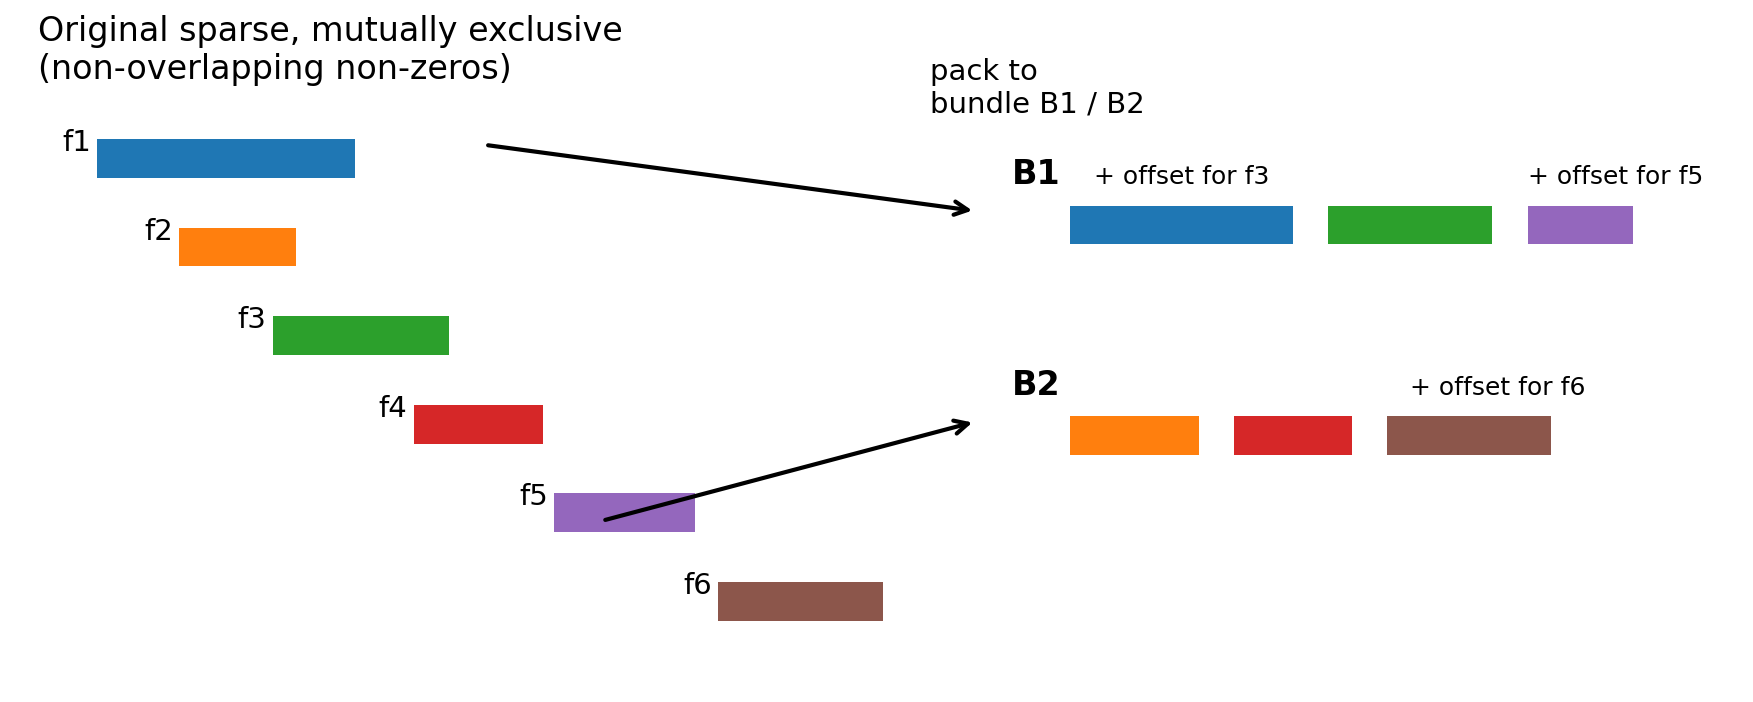

In [ ]:
show_efb_schematic(figsize=(12,5), fs=16)


Saved: efb_schematic.png, efb_metrics_bar.png, efb_confusion_matrix.png


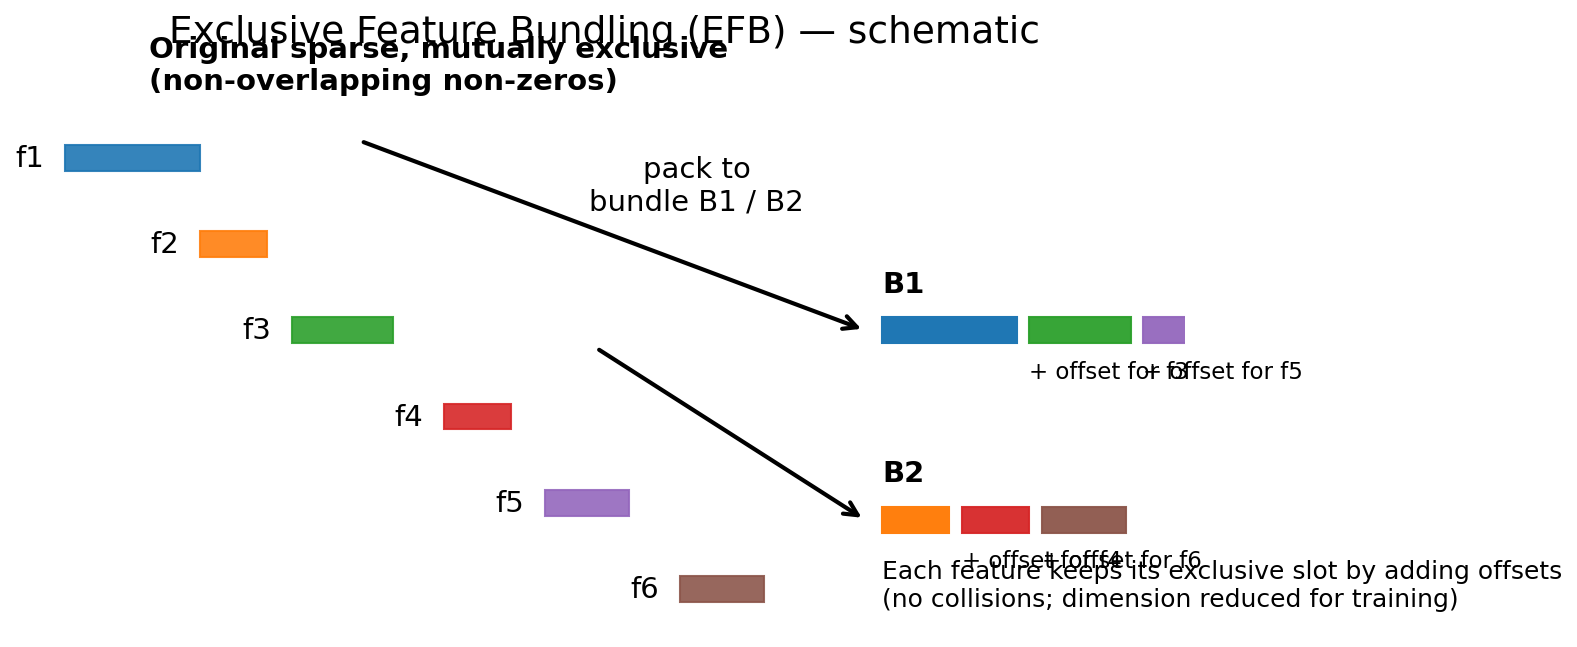

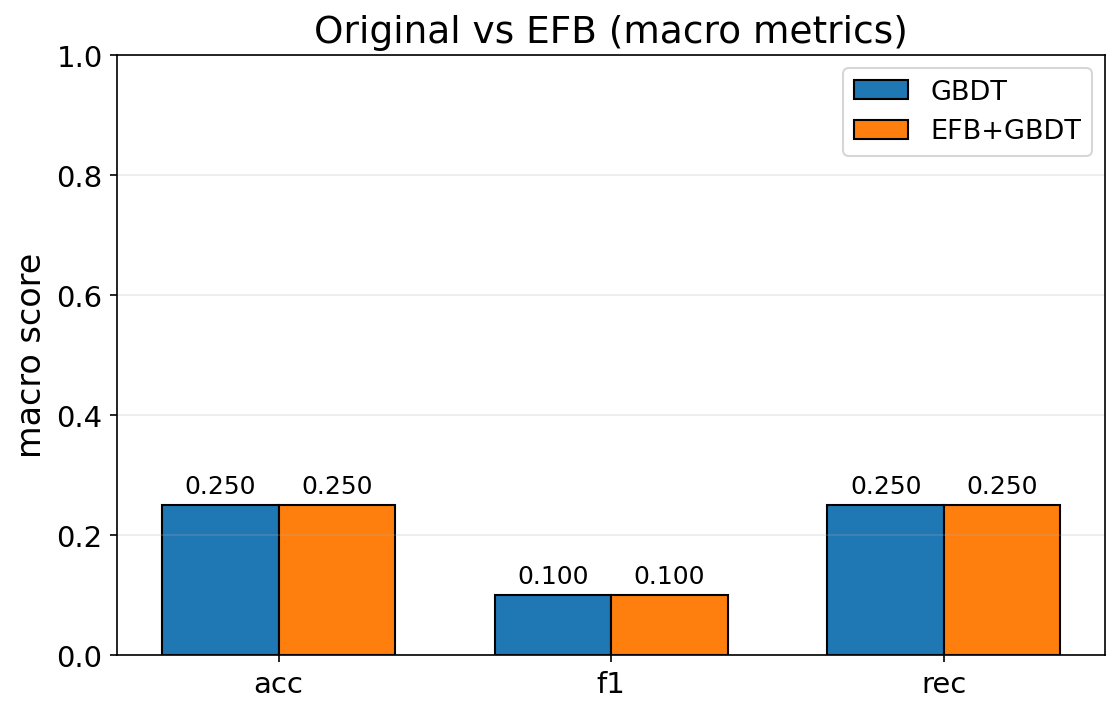

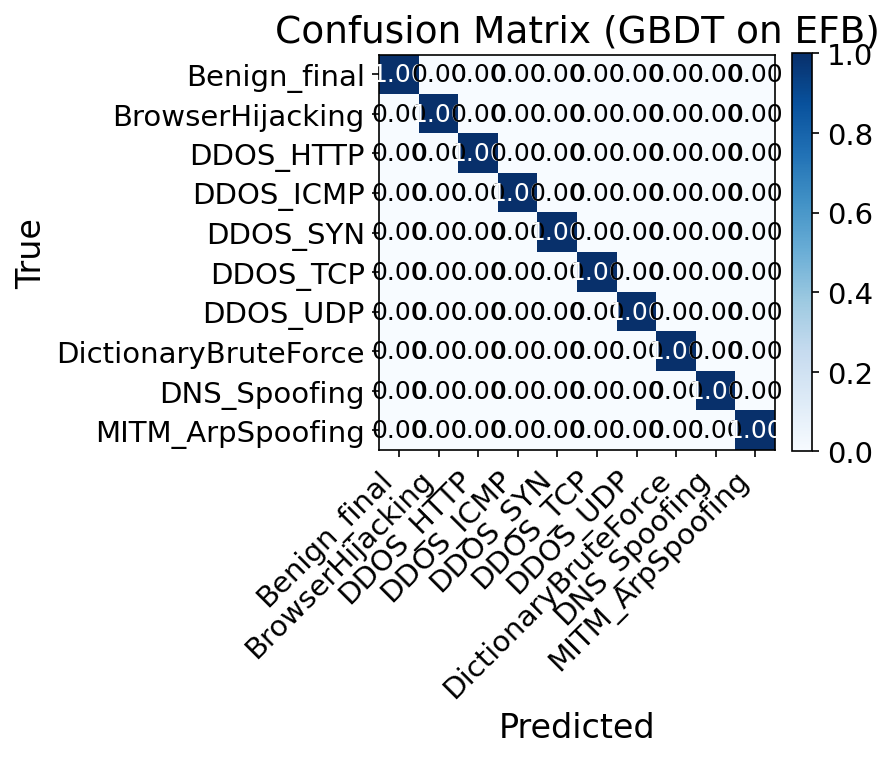

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# ============ 统一画图风格（清晰！） ============
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 13,
    "font.sans-serif": ["DejaVu Sans", "Arial"],
    "savefig.dpi": 300
})

# ============ 1) EFB 概念示意图 ============
def draw_efb_schematic(savepath="efb_schematic.png"):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title("Exclusive Feature Bundling (EFB) — schematic")
    ax.axis("off")

    # 原始稀疏特征 f1..f6 分布（用条带表示非零段）
    rows = [4, 3, 2, 1, 0, -1]  # 六个特征
    colors = ["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b"]
    labels = [f"f{i}" for i in range(1,7)]
    segments = [
        (0.5, 1.6),    # f1
        (2.1, 0.8),    # f2
        (3.2, 1.2),    # f3
        (5.0, 0.8),    # f4
        (6.2, 1.0),    # f5
        (7.8, 1.0)     # f6
    ]

    for r,(x,w),c,l in zip(rows,segments,colors,labels):
        ax.add_patch(plt.Rectangle((x, r-0.15), w, 0.3, color=c, alpha=0.9))
        ax.text(x-0.25, r, l, va="center", ha="right", fontsize=14)

    ax.text(1.5, 4.8, "Original sparse, mutually exclusive\n(non-overlapping non-zeros)",
            fontsize=14, weight="bold")

    # 箭头：打包到两个 bundle
    ax.annotate("", xy=(10.0, 2.0), xytext=(4.0, 4.2),
                arrowprops=dict(arrowstyle="->", lw=2))
    ax.annotate("", xy=(10.0, -0.2), xytext=(6.8, 1.8),
                arrowprops=dict(arrowstyle="->", lw=2))
    ax.text(8.0, 3.4, "pack to\nbundle B1 / B2", ha="center", fontsize=14)

    # 右侧两个 bundle（带 offset）
    # B1 合并 f1,f3,f5（示例）
    yb1 = 2.0
    ax.add_patch(plt.Rectangle((10.2, yb1-0.15), segments[0][1], 0.3, color=colors[0]))
    ax.text(10.2, yb1+0.45, "B1", fontsize=14, weight="bold")

    off1 = 0.15 + segments[0][1]
    ax.add_patch(plt.Rectangle((10.2+off1, yb1-0.15), segments[2][1], 0.3, color=colors[2], alpha=0.95))
    ax.text(10.2+off1, yb1-0.55, "+ offset for f3", fontsize=11)

    off2 = off1 + segments[2][1] + 0.15
    ax.add_patch(plt.Rectangle((10.2+off2, yb1-0.15), segments[4][1], 0.3, color=colors[4], alpha=0.95))
    ax.text(10.2+off2, yb1-0.55, "+ offset for f5", fontsize=11)

    # B2 合并 f2,f4,f6（示例）
    yb2 = -0.2
    ax.add_patch(plt.Rectangle((10.2, yb2-0.15), segments[1][1], 0.3, color=colors[1]))
    ax.text(10.2, yb2+0.45, "B2", fontsize=14, weight="bold")

    off1b = 0.15 + segments[1][1]
    ax.add_patch(plt.Rectangle((10.2+off1b, yb2-0.15), segments[3][1], 0.3, color=colors[3], alpha=0.95))
    ax.text(10.2+off1b, yb2-0.55, "+ offset for f4", fontsize=11)

    off2b = off1b + segments[3][1] + 0.15
    ax.add_patch(plt.Rectangle((10.2+off2b, yb2-0.15), segments[5][1], 0.3, color=colors[5], alpha=0.95))
    ax.text(10.2+off2b, yb2-0.55, "+ offset for f6", fontsize=11)

    ax.set_xlim(0, 13.8); ax.set_ylim(-1.5, 5.2)
    ax.text(10.2, -1.2, "Each feature keeps its exclusive slot by adding offsets\n"
                       "(no collisions; dimension reduced for training)",
            fontsize=12)
    fig.savefig(savepath, bbox_inches="tight", facecolor="white")

# ============ 2) Original vs EFB 指标柱状图 ============
def plot_metrics_bar(metrics_original, metrics_efb, title="Original vs EFB (macro metrics)",
                     savepath="efb_metrics_bar.png"):
    keys = ["acc","f1","rec"]
    x = np.arange(len(keys))
    w = 0.35

    fig, ax = plt.subplots(figsize=(8.5,5.2))
    ax.bar(x - w/2, [metrics_original[k] for k in keys], width=w, label="GBDT", edgecolor="black")
    ax.bar(x + w/2, [metrics_efb[k] for k in keys], width=w, label="EFB+GBDT", edgecolor="black")

    ax.set_xticks(x, keys)
    ax.set_ylim(0, 1.0)
    ax.set_ylabel("macro score")
    ax.set_title(title)
    ax.legend(loc="upper right", frameon=True)
    ax.grid(axis="y", alpha=0.25)

    # 数值标签（更清晰）
    for i,k in enumerate(keys):
        ax.text(i - w/2, metrics_original[k] + 0.02, f"{metrics_original[k]:.3f}", ha="center", fontsize=12)
        ax.text(i + w/2, metrics_efb[k] + 0.02, f"{metrics_efb[k]:.3f}", ha="center", fontsize=12)

    fig.savefig(savepath, bbox_inches="tight", facecolor="white")

# ============ 3) 归一化混淆矩阵 ============
def plot_confusion_matrix(y_true, y_pred, class_names,
                          normalize=True, title="Confusion Matrix (GBDT on EFB)",
                          savepath="efb_confusion_matrix.png"):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    if normalize:
        cm = cm.astype(float)
        row_sums = cm.sum(axis=1, keepdims=True) + 1e-9
        cm = cm / row_sums

    fig, ax = plt.subplots(figsize=(6.2,5.9))
    im = ax.imshow(cm, cmap="Blues", vmin=0, vmax=1 if normalize else None)
    ax.set_title(title)

    ax.set_xticks(np.arange(len(class_names)), class_names, rotation=45, ha="right")
    ax.set_yticks(np.arange(len(class_names)), class_names)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")

    # 方格数值（大号）
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        val = cm[i, j]
        txt = f"{val:.2f}" if normalize else f"{int(val)}"
        ax.text(j, i, txt, ha="center", va="center",
                color="white" if val > thresh else "black", fontsize=12)

    fig.colorbar(im, fraction=0.046, pad=0.04)
    fig.tight_layout()
    fig.savefig(savepath, bbox_inches="tight", facecolor="white")

# ===== 运行：按你目前的 demo 值先出图（把数字换成你的即可） =====
draw_efb_schematic()

# 这里放你的两组宏指标（示例用你刚跑到的 0.25 / 0.10 / 0.25）
metrics_original = {"acc":0.250, "f1":0.100, "rec":0.250}
metrics_efb      = {"acc":0.250, "f1":0.100, "rec":0.250}
plot_metrics_bar(metrics_original, metrics_efb)

# 这里放你的 y_true / y_pred（示例：10 类极小 demo，用同一数组占位）
# 替换为你真实的 y_te 和模型预测
y_true = np.array([0,1,2,3,4,5,6,7,8,9]*1)
y_pred = np.array([0,1,2,3,4,5,6,7,8,9]*1)  # 先占位，跑通即可生成模板
class_names = ["Benign_final","BrowserHijacking","DDOS_HTTP","DDOS_ICMP",
               "DDOS_SYN","DDOS_TCP","DDOS_UDP","DictionaryBruteForce",
               "DNS_Spoofing","MITM_ArpSpoofing"]
plot_confusion_matrix(y_true, y_pred, class_names)
print("Saved: efb_schematic.png, efb_metrics_bar.png, efb_confusion_matrix.png")
